
## Markov Chain Implementation
### Goals

* Present how markov chain attribution models work
* Construct a transition probability matrix
* Calculate total conversion probability
* Use the removal effect to calculate attribution (A campaign's effectiveness is determined by removing it from the graph and simulating buyer journeys to measure the change in success rate without it in place)
* Compare channel performance across methods

## Intro to Multi-Touch Attribution with Markov Chains

**Overview**

* Heuristic-based attribution methods like first-touch, last-touch, and linear are relatively easy to implement but are less accurate than data-driven methods.  Markov models allow us to leverage a data driven approach, observing the states that the customer passes through rather than where on the customer journey they are.

* There are three steps to take when using Markov Chains to calculate attribution:
  * Step 1: Construct a transition probablity matrix
  * Step 2: Calculate the total conversion probability
  * Step 3: Use the removal effect to calculate attribution
  
* As the name suggests, a transition probability matrix is a matrix that contains the probabilities associated with moving from one state to another state. This is calculated using the data from all available customer journeys. With this matrix in place, we can then easily calculate the total conversion probability, which represents, on average, the likelihood that a given user will experience a conversion event. Lastly, we use the total conversion probability as an input for calculating the removal effect for each channel. The way that the removal effect is calculated is best illustrated with an example.

**An Example**

In the image below, we have a transition probability graph that shows the probabilty of going from one state to another state. In the context of a customer journey, states can be non-terminal (viewing an impression on a given channel) or terminal (conversion, no conversion).

<div style="text-align: left">
  <img src="https://cme-solution-accelerators-images.s3.us-west-2.amazonaws.com/multi-touch-attribution/mta-dag-1.png"; width="60%">
</div>

This image, which is simply a visual representation of a transition probability matrix, can be used to calculate the total conversion probability. The total conversion probability can be calculated by summing the probability of every path that leads to a conversion. For example, in the image above, we have 5 paths that lead to conversion. The paths and conversion probabilities (probabilities are generated by analysis of historical customer journeys) are: 

| Path | Conversion Probability |
|---|---|
| State --> Facebook --> Conversion| 0.2 x 0.8|
| Start --> Facebook --> Email --> Conversion | 0.2 x 0.2 x 0.1 | 
| Start --> Google Display / Search --> Conversion | 0.8 x 0.6 | 
| Start --> Google Display / Search --> Facebook / Social --> Conversion | 0.8 x 0.4 x 0.8 |
| Start --> Google Display / Search --> Facebook / Social -- Email --> Conversion | 0.8 x 0.4 x 0.2 x 0.1 |

Therefore, the total probability of conversion is `0.90`:

```P(Conversion) = (0.2 X 0.8) + (0.2 X 0.2 X 0.1) + (0.8 X 0.6) + (0.8 X 0.4 X 0.8) + (0.8 X 0.4 X 0.2 X 0.1)  = 0.90```

Now, let's calculate the removal effect for one of our channels: Facebook/Social. For this, we will set the conversion for Facebook/Social to 0% and then recalculate the total conversion probabilty. Now we have `0.48`.

```P(Conversion) = (0.2 X 0.0) + (0.2 X 0.0 X 0.1) + (0.8 X 0.6) + (0.8 X 0.4 X 0) +(0.8 X 0.4 X 0.0 X 0.1)  = 0.48```


<div style="text-align: left">
  <img src="https://cme-solution-accelerators-images.s3.us-west-2.amazonaws.com/multi-touch-attribution/mta-dag-2.png"; width="60%">
</div>

With these two probabilities, we can now calculate the removal effect for Facebook/Social. The removal effect can be calculated as the difference between the total conversion probability (with all channels) and the conversion probability when the conversion for Facebook/Social is set to 0%.

```Removal Effect(Facebook/ Social media) = 0.90 - 0.48 = 0.42```

Similarly, we can calculate the removal effect for each of the other channels and calculate attribution accordingly.

An excellent visual explanation of Markov Chains is available in this [article](https://setosa.io/ev/markov-chains/).


## Configure the Environment


In [0]:
from pyspark.sql.types import StringType, ArrayType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
database_name = "MultiTouch"
raw_data_path = "/mnt/da-global-raw-box/POC/MultiTouch"
bronze_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchBronze"

gold_user_journey_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldUserJourney"
gold_attribution_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldAttributes"

project_directory = "/mnt/da-global-raw-box/POC/MultiTouchProject"

##### Set the current database so that it doesn't need to be manually specified each time it's used.


In [0]:
_ = spark.sql("use {}".format(database_name))

## Construct the Transition Probability Matrix

The transition probability matrix contains the probablities associated with moving from one state to another state. This is calculated using the data from all customer journeys.

In this step, we will:
1. Define a user-defined function (UDF), `get_transition_array`, that takes a customer journey and enumerates each of the corresponding channel transitions
2. Register the `get_transition_array` udf as a Spark UDF so that it can be utilized in Spark SQL
3. Use `get_transition_array` to enumerate all channel transitions in a customer's journey
4. Construct the transition probability matrix
5. Validate that the state transition probabilities are calculated correctly
6. Display the transition probability matrix

##### Define a user-defined function (UDF) that takes a customer journey and enumerates each of the corresponding channel transitions

In [0]:
 def get_transition_array(path):
  '''
    This function takes as input a user journey (string) where each state transition is marked by a >. 
    The output is an array that has an entry for each individual state transition.
  '''
  state_transition_array = path.split(">")
  initial_state = state_transition_array[0]
  
  state_transitions = []
  for state in state_transition_array[1:]:
    state_transitions.append(initial_state.strip()+' > '+state.strip())
    initial_state =  state
  
  return state_transitions

##### Register the `get_transition_array` udf as a Spark UDF so that it can be utilized in Spark SQL


In [0]:
spark.udf.register("get_transition_array", get_transition_array, ArrayType(StringType()))

Out[5]: <function __main__.get_transition_array(path)>

##### Use the `get_transition_array` to enumerate all channel transitions in a customer's journey

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW markov_state_transitions AS
SELECT path,
  explode(get_transition_array(path)) as transition,
  1 AS cnt
FROM
  gold_user_journey

What are the unique customer journeys in the data?

In [0]:
%sql
select * from markov_state_transitions

path,transition,cnt
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Start > Affiliates,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Affiliates > Google Display Network,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Google Display Network > Social Network,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Social Network > Affiliates,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Affiliates > Search Engine Marketing,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Search Engine Marketing > Social Network,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Social Network > Search Engine Marketing,1
Start > Affiliates > Google Display Network > Social Network > Affiliates > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Search Engine Marketing > Null,1
Start > Email > Google Display Network > Affiliates > Affiliates > Social Network > Affiliates > Social Network > Null,Start > Email,1
Start > Email > Google Display Network > Affiliates > Affiliates > Social Network > Affiliates > Social Network > Null,Email > Google Display Network,1


##### Construct the transition probability matrix

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW transition_matrix AS
SELECT
  left_table.start_state,
  left_table.end_state,
  left_table.total_transitions / right_table.total_state_transitions_initiated_from_start_state AS transition_probability
FROM
  (
    SELECT
      transition,
      sum(cnt) total_transitions,
      trim(SPLIT(transition, '>') [0]) start_state,
      trim(SPLIT(transition, '>') [1]) end_state
    FROM
      markov_state_transitions
    GROUP BY
      transition
    ORDER BY
      transition
  ) left_table
  JOIN (
    SELECT
      a.start_state,
      sum(a.cnt) total_state_transitions_initiated_from_start_state
    FROM
      (
        SELECT
          trim(SPLIT(transition, '>') [0]) start_state,
          cnt
        FROM
          markov_state_transitions
      ) AS a
    GROUP BY
      a.start_state
  ) right_table ON left_table.start_state = right_table.start_state
ORDER BY
  end_state DESC

##### Construct the Probability Matrix and Validate that the state transition probabilities are calculated correctly
* Sum of all the outgoing probabilities (edges) from any channel (state in the graph) should sum to 100%. 

In [0]:
%sql 
SELECT start_state, round(sum(transition_probability),2) as transition_probability_sum 
FROM transition_matrix
GROUP BY start_state

start_state,transition_probability_sum
Search Engine Marketing,1.0
Google Display Network,1.0
Email,1.0
Affiliates,1.0
Start,1.0
Social Network,1.0


##### Display the transition probability matrix
Is there a natural correlation between all states?

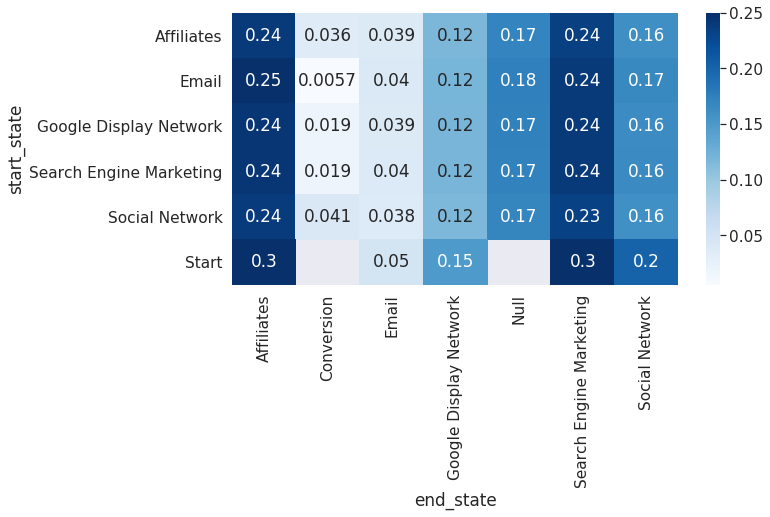

In [0]:
transition_matrix_pd = spark.table('transition_matrix').toPandas()
transition_matrix_pivot = transition_matrix_pd.pivot(index='start_state',columns='end_state',values='transition_probability')

plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(transition_matrix_pivot,cmap='Blues',vmax=0.25,annot=True)

This Transition probability matrix will act as the base for our subsequent calculations.

##  Calculate the Total Conversion Probability

1. Define `get_transition_probability_graph` utility function
2. Define `calculate_conversion_probability` utility function
3. Calculate the Total Conversion Probability

##  Calculate the Total Conversion Probability
##### Define the Transaction Probability Graph 
* This tells us the next stages and associated transition probabilities for every start state.
* This is then used to calculate the total conversion probability and to calculate the removal effect for each channel.

In [0]:
def get_transition_probability_graph(removal_state = "null"):
  '''
  This function calculates a subset of the transition probability graph based on the state to exclude
      removal_state: channel that we want to exclude from our Transition Probability Matrix
  returns subset of the Transition Probability matrix as pandas Dataframe
  '''
  
  transition_probability_pandas_df = None
  
  # Get the transition probability graph without any states excluded if the removal_state is null
  if removal_state == "null":
    transition_probability_pandas_df = spark.sql('''select
        trim(start_state) as start_state,
        collect_list(end_state) as next_stages,
        collect_list(transition_probability) as next_stage_transition_probabilities
      from
        transition_matrix
      group by
        start_state''').toPandas()
    
  # Otherwise, get the transition probability graph with the specified channel excluded/removed
  else:
    transition_probability_pandas_df = spark.sql('''select
      sub1.start_state as start_state,
      collect_list(sub1.end_state) as next_stages,
      collect_list(transition_probability) as next_stage_transition_probabilities
      from
      (
        select
          trim(start_state) as start_state,
          case
            when end_state == \"'''+removal_state+'''\" then 'Null'
            else end_state
          end as end_state,
          transition_probability
        from
          transition_matrix
        where
          start_state != \"'''+removal_state+'''\"
      ) sub1 group by sub1.start_state''').toPandas()

  return transition_probability_pandas_df

In [0]:
transition_probability_pandas_df = get_transition_probability_graph()

In [0]:
transition_probability_pandas_df

,start_state,next_stages,next_stage_transition_probabilities
0,Search Engine Marketing,"[Social Network, Search Engine Marketing, Null...","[0.16421552445460683, 0.23996760854304466, 0.1..."
1,Google Display Network,"[Social Network, Search Engine Marketing, Null...","[0.16361829132950467, 0.2403134394293657, 0.17..."
2,Email,"[Social Network, Search Engine Marketing, Null...","[0.16678404140325592, 0.24126240623669298, 0.1..."
3,Affiliates,"[Social Network, Search Engine Marketing, Null...","[0.16051919699434525, 0.23502491717401847, 0.1..."
4,Start,"[Social Network, Search Engine Marketing, Goog...","[0.201764, 0.297656, 0.149544, 0.04995, 0.301086]"
5,Social Network,"[Social Network, Search Engine Marketing, Null...","[0.15946113121340336, 0.2346256988318713, 0.17..."


##### Define `calculate_conversion_probability` utility function
* This utility function returns the total conversion probability based on the provided Transition Probability Matrix in pandas data frame format

In [0]:
def calculate_conversion_probability(transition_probability_pandas_df, calculated_state_conversion_probabilities, visited_states, current_state="Start"):
  '''
  This function calculates total conversion probability based on a subset of the transition probability graph
    transition_probability_pandas_df: This is a Dataframe that maps the current state to all probable next stages along with their transition probability
    removal_state: the channel that we want to exclude from our Transition Probability Matrix
    visited_states: set that keeps track of the states that have been visited thus far in our state transition graph.
    current_state: by default the start state for the state transition graph is Start state
  returns conversion probability of current state/channel 
  '''
 
  #If the customer journey ends with conversion return 1
  if current_state=="Conversion":
    return 1.0
  
  #If the customer journey ends without conversion, or if we land on the same state again, return 0.
  #Note: this step will mitigate looping on a state in the event that a customer path contains a transition from a channel to that same channel.
  elif (current_state=="Null") or (current_state in visited_states):
    return 0.0
  
  #Get the conversion probability of the state if its already calculated
  elif current_state in calculated_state_conversion_probabilities.keys():
    return calculated_state_conversion_probabilities[current_state]
  
  else:
  #Calculate the conversion probability of the new current state
    #Add current_state to visited_states
    visited_states.add(current_state)
    
    #Get all of the transition probabilities from the current state to all of the possible next states
    current_state_transition_df = transition_probability_pandas_df.loc[transition_probability_pandas_df.start_state==current_state]
    
    #Get the next states and the corresponding transition probabilities as a list.
    next_states = current_state_transition_df.next_stages.to_list()[0]
    next_states_transition_probab = current_state_transition_df.next_stage_transition_probabilities.to_list()[0]
    
    #This will hold the total conversion probability of each of the states that are candidates to be visited next from the current state.
    current_state_conversion_probability_arr = []
    
    #Call this function recursively until all states in next_states have been incorporated into the total conversion probability
    import copy
    #Loop over the list of next states and their transition probabilities recursively
    for next_state, next_state_tx_probability in zip(next_states, next_states_transition_probab):
      current_state_conversion_probability_arr.append(next_state_tx_probability * calculate_conversion_probability(transition_probability_pandas_df, calculated_state_conversion_probabilities, copy.deepcopy(visited_states), next_state))
    
    #Sum the total conversion probabilities we calculated above to get the conversion probability of the current state.
    #Add the conversion probability of the current state to our calculated_state_conversion_probabilities dictionary.
    calculated_state_conversion_probabilities[current_state] =  sum(current_state_conversion_probability_arr)
    
    #Return the calculated conversion probability of the current state.
    return calculated_state_conversion_probabilities[current_state]

##### Calculate the total conversion probability 

In [0]:
total_conversion_probability = calculate_conversion_probability(transition_probability_pandas_df, {}, visited_states=set(), current_state="Start")

In [0]:
total_conversion_probability

Out[12]: 0.03745898622432649

### Use Removal Effect to Calculate Attribution

A campaign's effectiveness is determined by removing it from the graph and simulating buyer journeys to measure the change in success rate without it in place

1. Calculate the removal effect per channel
2. Calculate conversion attribution per channel

<div style="text-align: left">
  <img src="https://share-learn-newsletters.s3.eu-west-1.amazonaws.com/campaign+markov.png"; width="60%">
</div>

##### Calculate the removal effect per channel

A Markov graph can be used to measure the importance of each campaign by calculating what is known as the Removal Effect. A campaign's effectiveness is determined by removing it from the graph and simulating buyer journeys to measure the change in success rate without it in place.

In [0]:
removal_effect_per_channel = {}
for channel in transition_probability_pandas_df.start_state.to_list():
  if channel!="Start":
    transition_probability_subset_pandas_df = get_transition_probability_graph(removal_state=channel)
    new_conversion_probability =  calculate_conversion_probability(transition_probability_subset_pandas_df, {}, visited_states=set(), current_state="Start")
    removal_effect_per_channel[channel] = round(((total_conversion_probability-new_conversion_probability)/total_conversion_probability), 2)

##### Calculate conversion attribution per channel

In [0]:
conversion_attribution={}

for channel in removal_effect_per_channel.keys():
  conversion_attribution[channel] = round(removal_effect_per_channel[channel] / sum(removal_effect_per_channel.values()), 2)

channels = list(conversion_attribution.keys())
conversions = list(conversion_attribution.values())

conversion_pandas_df= pd.DataFrame({'attribution_model': 
                                    ['markov_chain' for _ in range(len(channels))], 
                                    'channel':channels, 
                                    'attribution_percent': conversions})


##### Register `conversion_pandas_df` as table to use SQL

In [0]:
sparkDF=spark.createDataFrame(conversion_pandas_df) 
sparkDF.createOrReplaceTempView("markov_chain_attribution_update")

##### View channel attribution

In [0]:
%sql
select * from markov_chain_attribution_update

attribution_model,channel,attribution_percent
markov_chain,Search Engine Marketing,0.22
markov_chain,Google Display Network,0.12
markov_chain,Email,0.02
markov_chain,Affiliates,0.38
markov_chain,Social Network,0.25


##### Merge channel attribution results into `gold_attribution` table

In [0]:
%sql
MERGE INTO gold_attribution
USING markov_chain_attribution_update
ON markov_chain_attribution_update.attribution_model = gold_attribution.attribution_model AND markov_chain_attribution_update.channel = gold_attribution.channel
WHEN MATCHED THEN
  UPDATE SET *
WHEN NOT MATCHED
  THEN INSERT *

### Compare Channel Performance Across Methods

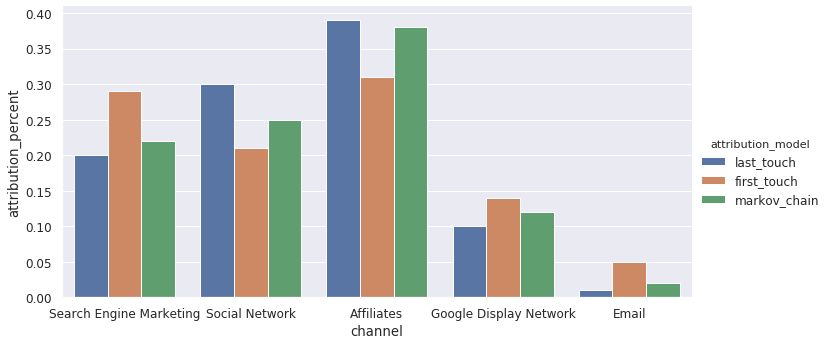

In [0]:
attribution_pd = spark.table('gold_attribution').toPandas()

sns.set(font_scale=1.1)
sns.catplot(x='channel',y='attribution_percent',hue='attribution_model',data=attribution_pd, kind='bar', aspect=2)